# Train a Variational Autoencoder on MNIST/ FashionMNIST dataset

In [1]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
# path_save = '/content/drive/MyDrive/colab_files/'

In [2]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import sklearn.manifold
import os
import numpy as np

In [3]:
path_save='./'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset='FashionMNIST'


In [4]:
# ------------Dataset-----------------------------
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

if(dataset=='FashionMNIST'):
    train_data = datasets.FashionMNIST(
        root = path_save,
        train = True,                         
        transform = ToTensor(), 
        download = True,            
    )
    test_data = datasets.FashionMNIST(
        root = path_save, 
        train = False, 
        transform = ToTensor()
    )
elif(dataset == 'MNIST'):
    train_data = datasets.MNIST(
    root = path_save,
    train = True,                         
    transform = ToTensor(), 
    download = True,            
    )
    test_data = datasets.MNIST(
        root = path_save, 
        train = False, 
        transform = ToTensor()
    )

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=2),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1),
}

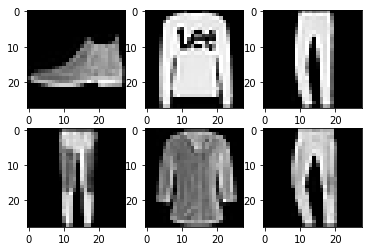

In [5]:
# ----------lets visualise some samples from the dataset ----------
test_loader = loaders['test']
examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
 plt.subplot(2,3,i+1)
 plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
# full network of VAE  
# We will not use this. 

from torch.nn.modules.container import ModuleList
# create the full encoder-decoder model
import torch.nn as nn

def sample_latent_features(mean, logvar):
  batch_size = logvar.shape[0]
  random = torch.randn_like(logvar)
  return mean + (torch.exp(0.5 * logvar)) * random


class VAE(nn.Module):
    def __init__(self):
        
        super(VAE, self).__init__()

        self.conv1 = nn.Conv2d(1,64,(5,5))
        self.maxpool2 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(64,64,(3,3))        
        self.conv3 = nn.Conv2d(64,32,(3,3)) 
        self.flatten = Flatten()
        self.linear1 = nn.Linear(32,16)
        self.linear21 = nn.Linear(16,2)
        self.linear22 = nn.Linear(16,2)
        # -----for the decoder part----------
        self.linear3 = nn.Linear(2,64)
        self.conv2t1 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t2 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t3 = nn.ConvTranspose2d(64,64,(3,3))
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv2t4 = nn.ConvTranspose2d(64,1,(5,5))

    def forward(self,x):
        #-----------encoder------------  
        x=self.conv1(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv2(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv3(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x) 
        mean = self.linear21(x)
        logvar = self.linear22(x)
        x = sample_latent_features(mean, logvar)
        encoding = x
        #-----------decoder------------                  
        x = self.linear3(x)
        # x = x.view(x.shape[0], 64, 1, 1)        
        x = x.reshape(x.shape[0], 64, 1, 1)        
        x = self.conv2t1(x)
        x = nn.functional.relu(x)
        x = self.conv2t2(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t3(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t4(x)
        x = nn.functional.relu(x)

        return x, mean, logvar, encoding  # return x for visualization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_VAE = VAE().to(device)

# out = model(torch.rand(100,1,28,28))
# print('Model Summary')
i=28
from torchsummary import summary
summary(model_VAE,input_size=(1,i,i))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
         MaxPool2d-2           [-1, 64, 12, 12]               0
            Conv2d-3           [-1, 64, 10, 10]          36,928
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Conv2d-5             [-1, 32, 3, 3]          18,464
         MaxPool2d-6             [-1, 32, 1, 1]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 16]             528
            Linear-9                    [-1, 2]              34
           Linear-10                    [-1, 2]              34
           Linear-11                   [-1, 64]             192
  ConvTranspose2d-12             [-1, 64, 3, 3]          36,928
  ConvTranspose2d-13             [-1, 64, 5, 5]          36,928
         Upsample-14           [-1, 64,

In [8]:
# The network of VAE divided in encoder and decoder networks separately and then merged

from torch.nn.modules.container import ModuleList
# create the full encoder-decoder model
import torch.nn as nn

def sample_latent_features(mean, logvar):
  batch_size = logvar.shape[0]
  random = torch.randn_like(logvar)
  return mean + (torch.exp(0.5 * logvar)) * random


class VAE_encoder(nn.Module):
    def __init__(self):
        
        super(VAE_encoder, self).__init__()

        self.conv1 = nn.Conv2d(1,64,(5,5))
        self.maxpool2 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(64,64,(3,3))        
        self.conv3 = nn.Conv2d(64,32,(3,3)) 
        self.flatten = Flatten()
        self.linear1 = nn.Linear(32,16)
        self.linear21 = nn.Linear(16,2)
        self.linear22 = nn.Linear(16,2)
#         # -----for the decoder part----------
#         self.linear3 = nn.Linear(3,64)
#         self.conv2t1 = nn.ConvTranspose2d(64,64,(3,3))
#         self.conv2t2 = nn.ConvTranspose2d(64,64,(3,3))
#         self.conv2t3 = nn.ConvTranspose2d(64,64,(3,3))
#         self.upsample = nn.Upsample(scale_factor=2)
#         self.conv2t4 = nn.ConvTranspose2d(64,1,(5,5))

    def forward(self,x):
        #-----------encoder------------  
        x=self.conv1(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv2(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv3(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x) 
        mean = self.linear21(x)
        logvar = self.linear22(x)
        x = sample_latent_features(mean, logvar)
        encoding = x
#         #-----------decoder------------                  
#         x = self.linear3(x)
#         # x = x.view(x.shape[0], 64, 1, 1)        
#         x = x.reshape(x.shape[0], 64, 1, 1)        
#         x = self.conv2t1(x)
#         x = nn.functional.relu(x)
#         x = self.conv2t2(x)
#         x = nn.functional.relu(x)
#         x = self.upsample(x)
#         x = self.conv2t3(x)
#         x = nn.functional.relu(x)
#         x = self.upsample(x)
#         x = self.conv2t4(x)
#         x = nn.functional.relu(x)

        return x, mean, logvar  # return x for visualization


class VAE_decoder(nn.Module):
    def __init__(self):
        
        super(VAE_decoder, self).__init__()

#         self.conv1 = nn.Conv2d(1,64,(5,5))
#         self.maxpool2 = nn.MaxPool2d((2,2))
#         self.conv2 = nn.Conv2d(64,64,(3,3))        
#         self.conv3 = nn.Conv2d(64,32,(3,3)) 
#         self.flatten = nn.Flatten()
#         self.linear1 = nn.Linear(32,16)
#         self.linear21 = nn.Linear(16,3)
#         self.linear22 = nn.Linear(16,3)
#         # -----for the decoder part----------
        self.linear3 = nn.Linear(2,64)
        self.conv2t1 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t2 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t3 = nn.ConvTranspose2d(64,64,(3,3))
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv2t4 = nn.ConvTranspose2d(64,1,(5,5))

    def forward(self,x):
        #-----------encoder------------  
#         x=self.conv1(x)
#         x=nn.functional.relu(x)
#         x=self.maxpool2(x)
#         x=self.conv2(x)
#         x=nn.functional.relu(x)
#         x=self.maxpool2(x)
#         x=self.conv3(x)
#         x=nn.functional.relu(x)
#         x=self.maxpool2(x)
#         x = self.flatten(x)
#         x = self.linear1(x) 
#         mean = self.linear21(x)
#         logvar = self.linear22(x)
#         x = sample_latent_features(mean, logvar)
#         encoding = x
#         #-----------decoder------------                  
        x = self.linear3(x)
        # x = x.view(x.shape[0], 64, 1, 1)        
        x = x.reshape(x.shape[0], 64, 1, 1)        
        x = self.conv2t1(x)
        x = nn.functional.relu(x)
        x = self.conv2t2(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t3(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t4(x)
        x = nn.functional.relu(x)

        return x  # return x for visualization

class VAE(nn.Module):
    def __init__(self,encoder,decoder):
        
        super(VAE, self).__init__()
        self.encoder =  encoder
        self.decoder =  decoder

    def forward(self,x):
        encoding, mean, logvar = self.encoder(x)
        out = self.decoder(encoding)

        return out , mean, logvar, encoding  # return x for visualization


In [9]:
def create_model():
    global model_VAE_encoder
    global model_VAE_decoder
    global model_VAE
    
    model_VAE_encoder = VAE_encoder().to(device)
    model_VAE_decoder = VAE_decoder().to(device)
    model_VAE = VAE(model_VAE_encoder,model_VAE_decoder).to(device)
    
    return 

In [10]:
create_model()
# check model summary
i=28
from torchsummary import summary
summary(model_VAE,input_size=(1,i,i))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
         MaxPool2d-2           [-1, 64, 12, 12]               0
            Conv2d-3           [-1, 64, 10, 10]          36,928
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Conv2d-5             [-1, 32, 3, 3]          18,464
         MaxPool2d-6             [-1, 32, 1, 1]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 16]             528
            Linear-9                    [-1, 2]              34
           Linear-10                    [-1, 2]              34
      VAE_encoder-11  [[-1, 2], [-1, 2], [-1, 2]]               0
           Linear-12                   [-1, 64]             192
  ConvTranspose2d-13             [-1, 64, 3, 3]          36,928
  ConvTranspose2d-14             [-1,

In [11]:
# -------------define the loss function, optimizer and training function ------------

def vae_loss(y_true, y_pred, mean, logvar, loss_weights):
    w1, w2 = loss_weights
    myloss = nn.MSELoss(reduction='mean')
    reconstruction_loss_batch1 = myloss(y_pred,y_true)    
    reconstruction_loss_batch = reconstruction_loss_batch1*w1
    
    kl_loss = 1 + logvar - mean**2 - torch.exp(logvar)
    kl_loss_batch = torch.mean(kl_loss)
    kl_loss_batch1 = kl_loss_batch*(-0.5)       
    kl_loss_batch = kl_loss_batch1*w2

    return reconstruction_loss_batch + kl_loss_batch, reconstruction_loss_batch1, kl_loss_batch1

def train(num_epochs, model, loaders, loss_weights):
    # optimizer
    optimizer_VAE = torch.optim.Adam(model_VAE.parameters(), lr=0.001)

    r_losses=[]
    kl_losses=[]
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.to(device)
            output, mean, logvar, encoding = model(images)
            loss, r_loss, kl_loss = vae_loss(images, output, mean , logvar, loss_weights)
            kl_losses.append(kl_loss.cpu().detach().numpy())  
            r_losses.append(r_loss.cpu().detach().numpy())
            # clear gradients for this training step   
            optimizer_VAE.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward() # apply gradients
            optimizer_VAE.step()                

            if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
    return (r_losses,kl_losses)

# ----save the trained model with the arrays containing the loss values----------

def save_model(loss_weights, loss_arrays):
    (r_losses,kl_losses) = loss_arrays
    w1, w2 = loss_weights
    path_save1 = path_save+'saved_models/%s/VAE/'%(dataset)+'%.2f_%.2f/'%(w1,w2)

    if(not os.path.exists(path_save1)):
        os.makedirs(path_save1)
    
    np.save(path_save1+'r_losses', r_losses)
    np.save(path_save1+'kl_losses', kl_losses)

    state = {
        'state_dict': model_VAE.state_dict()}
    torch.save(state, path_save1 + 'model_VAE_FMINST_state')



In [12]:
# --------------lets define a function to load the saved loss weights and plot the loss values -----------------

def plot_losses(loss_weights):
    
    w1, w2 = loss_weights
    path_ = path_save+'saved_models/%s/VAE/'%(dataset)+'%.2f_%.2f/'%(w1,w2)
    r_losses = np.load(path_+'r_losses.npy')
    kl_losses = np.load(path_+'kl_losses.npy')

    # -----------------------------------------
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(r_losses, label='Reconstruction loss')
    plt.legend()
    plt.savefig(path_+'weights (reconstruction loss, kl loss) = (%f %f) loss.png'%(w1,w2))

    plt.subplot(1,2,2)
    plt.plot(kl_losses, label='Kl divergence Loss')
    plt.legend()
    plt.savefig(path_+'weights (reconstruction loss, kl loss) = (%f %f) loss.png'%(w1,w2))


Epoch [1/20], Step [100/600], Loss: 47.2811
Epoch [1/20], Step [200/600], Loss: 35.2826
Epoch [1/20], Step [300/600], Loss: 37.8116
Epoch [1/20], Step [400/600], Loss: 31.1893
Epoch [1/20], Step [500/600], Loss: 31.8819
Epoch [1/20], Step [600/600], Loss: 31.0198
Epoch [2/20], Step [100/600], Loss: 28.1931
Epoch [2/20], Step [200/600], Loss: 27.8711
Epoch [2/20], Step [300/600], Loss: 29.5486
Epoch [2/20], Step [400/600], Loss: 29.1868
Epoch [2/20], Step [500/600], Loss: 28.3405
Epoch [2/20], Step [600/600], Loss: 27.7429
Epoch [3/20], Step [100/600], Loss: 26.2773
Epoch [3/20], Step [200/600], Loss: 27.5812
Epoch [3/20], Step [300/600], Loss: 28.7746
Epoch [3/20], Step [400/600], Loss: 29.0459
Epoch [3/20], Step [500/600], Loss: 24.4437
Epoch [3/20], Step [600/600], Loss: 26.4366
Epoch [4/20], Step [100/600], Loss: 27.1325
Epoch [4/20], Step [200/600], Loss: 30.0399
Epoch [4/20], Step [300/600], Loss: 26.5584
Epoch [4/20], Step [400/600], Loss: 27.2644
Epoch [4/20], Step [500/600], Lo

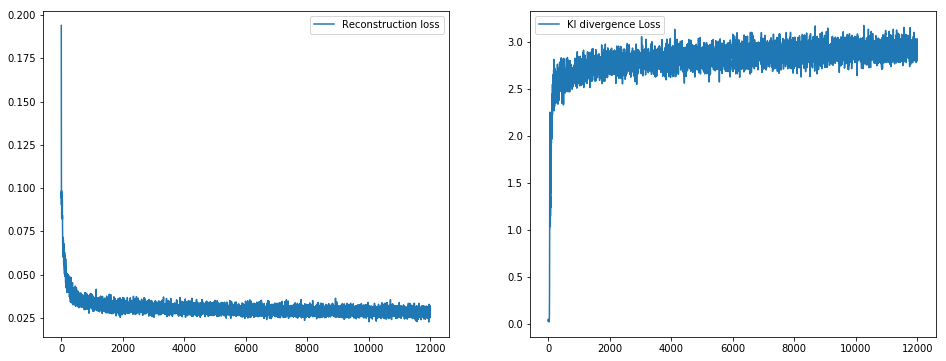

In [13]:
# ---- lets train the model and save it ---------
create_model()
num_epochs = 20; loss_weights = 784,1
loss_arrays = train(num_epochs, model_VAE, loaders,loss_weights)
save_model(loss_weights, loss_arrays)
plot_losses(loss_weights)

In [14]:
# # lets create another instance of VAE and train it for a different set of loss weights
# create_model()
# num_epochs = 20
# loss_weights = 1,1 #giving equal preference to both the losses
# loss_arrays = train(num_epochs, model_VAE, loaders,loss_weights)
# save_model(loss_weights, loss_arrays)
# plot_losses(loss_weights)

In [15]:
# # lets create another instance of VAE and train it for a different set of loss weights
# create_model()
# num_epochs = 20
# loss_weights = 1,0#giving equal preference to both the losses
# loss_arrays = train(num_epochs, model_VAE, loaders,loss_weights)
# save_model(loss_weights, loss_arrays)
# plot_losses(loss_weights)

In [16]:
# -----load the saved model-----------
loss_weights = 784,1
w1, w2 = loss_weights
path_save1 = path_save+'saved_models/%s/VAE/'%(dataset)+'%.2f_%.2f/'%(w1,w2)

state = torch.load(path_save1+'model_VAE_FMINST_state')
model_VAE.load_state_dict(state['state_dict'])

model_VAE.eval()

VAE(
  (encoder): VAE_encoder(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (flatten): Flatten()
    (linear1): Linear(in_features=32, out_features=16, bias=True)
    (linear21): Linear(in_features=16, out_features=2, bias=True)
    (linear22): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): VAE_decoder(
    (linear3): Linear(in_features=2, out_features=64, bias=True)
    (conv2t1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2t2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2t3): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (upsample): Upsample(scale_factor=2.0, mode=nearest)
    (conv2t4): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

In [17]:
# ----------get the predictions on the whole test set------------
lreconstructed, lmean, lvar, lencoding = [], [], [], []
limages=[]
llabels=[]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
def test():
    # Test the model   
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            test_output = model_VAE(images)
            
            reconstructed, mean, var, encoding = test_output
            reconstructed, mean, var, encoding = reconstructed.to("cpu"), mean.to("cpu"), var.to("cpu"), encoding.to("cpu")
            lreconstructed.append(np.array(reconstructed)); lmean.append(np.array(mean)); lvar.append(np.array(var)); lencoding.append(np.array(encoding))
            limages.append(np.array(images.to("cpu")))
            llabels.append(np.array(labels))
    pass

test()
test_mean_vae = np.vstack(lmean)
test_reconstructed_vae = np.vstack(lreconstructed)
test_logvar_vae = np.vstack(lvar)
test_encoding_vae = np.vstack(lencoding)
test_labels = np.hstack(llabels)
test_images = np.vstack(limages)

Real Images


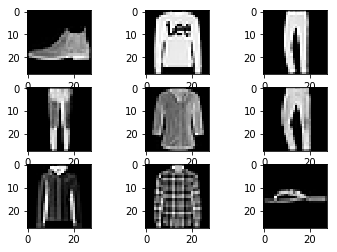

Reconstructed Images with Variational Autoencoder


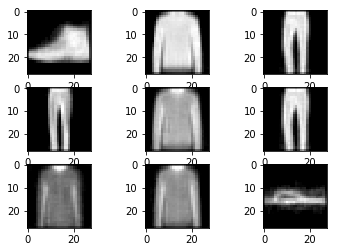

In [18]:
# ---------------lets visualise the real images and the reconstructed images from the test set--------------------
# Real Images
print("Real Images")
input = test_images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(input[i][0]*255, cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
output = test_reconstructed_vae
for i in range(9):
    plt.subplot(330 + 1 + i)    
    op_image = output[i][0]*255
    plt.imshow(op_image, cmap='gray')
plt.show()

In [19]:
# -----------lets check the values of predicted variance -----
print("log variance",test_logvar_vae[0])
print('Standard deviation',np.exp(test_logvar_vae[0]/2.0))
# (logvar = log (sigma **2)) = 2 log (sigma). Therefore, e^(logvar/2) = e^((2 log (sigma**2))/2) = sigma

log variance [-5.654742  -5.7323775]
Standard deviation [0.05916821 0.05691543]


[Text(0.5, 1.0, 'MNIST test data projection')]

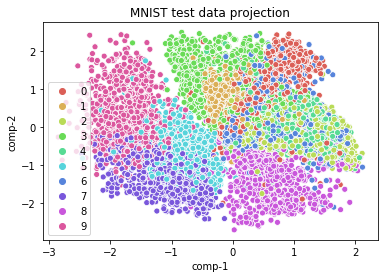

In [20]:
# ------------- visualisation of the feature space -----------
from sklearn.manifold import TSNE
import pandas as pd

use_tSNE = False

if(use_tSNE):
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(test_encoding_vae)
else:
    z = test_encoding_vae

y_test = test_labels
df = pd.DataFrame()
df["y"] = y_test
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

import seaborn as sns
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST test data projection")

In [21]:
# ----------get the predictions on the whole train set------------
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=2),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1),
}

lreconstructed, lmean, lvar, lencoding = [], [], [], []
limages=[]
llabels=[]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
def test():
    # Test the model   
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['train']:
            images = images.to(device)
            test_output = model_VAE(images)
            reconstructed, mean, var, encoding = test_output
            reconstructed, mean, var, encoding = reconstructed.to("cpu"), mean.to("cpu"), var.to("cpu"), encoding.to("cpu")
            lreconstructed.append(np.array(reconstructed)); lmean.append(np.array(mean)); lvar.append(np.array(var)); lencoding.append(np.array(encoding))
            limages.append(np.array(images.to("cpu")))
            llabels.append(np.array(labels))
    pass

test()
train_mean_vae = np.vstack(lmean)
train_reconstructed_vae = np.vstack(lreconstructed)
train_logvar_vae = np.vstack(lvar)
train_encoding_vae = np.vstack(lencoding)
train_labels_vae = np.hstack(llabels)
train_images_vae = np.vstack(limages)

[Text(0.5, 1.0, 'Feature space visualisation')]

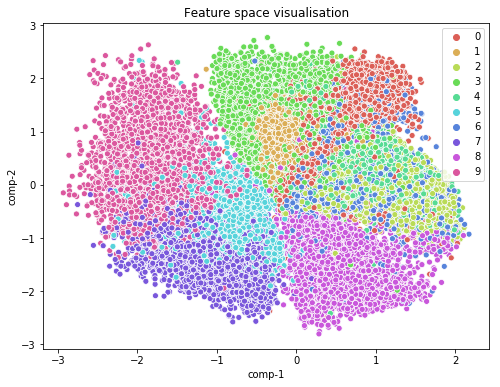

In [22]:
# ------------- visualisation of the feature space of some training data samples-----------

from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

num_samples = 40000
use_tSNE = False

if(use_tSNE):
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(train_encoding_vae[:num_samples])
else:
    z = train_encoding_vae[:num_samples]
    
y_ = train_labels_vae[:num_samples]#np.ones(shape=(test_encoding_vae.shape[0]))
df = pd.DataFrame()
df["y"] = y_
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

fig, (ax1) = plt.subplots(1,1, figsize=(8,6))

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df,ax=ax1
               ).set(title="Feature space visualisation")

# Autoencoder

In [23]:
import torch
from torch.nn.modules.container import ModuleList
# create the full encoder-decoder model
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        
        super(Autoencoder, self).__init__()

        self.conv1 = nn.Conv2d(1,64,(5,5))
        self.maxpool2 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(64,64,(3,3))        
        self.conv3 = nn.Conv2d(64,32,(3,3)) 
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32,16)
        self.linear21 = nn.Linear(16,2)
#         self.linear22 = nn.Linear(16,2)
        # -----for the decoder part----------
        self.linear3 = nn.Linear(2,64)
        self.conv2t1 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t2 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t3 = nn.ConvTranspose2d(64,64,(3,3))
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv2t4 = nn.ConvTranspose2d(64,1,(5,5))

    def forward(self,x):
        #-----------encoder------------  
        x=self.conv1(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv2(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv3(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear21(x)
#         mean = self.linear21(x)
#         logvar = self.linear22(x)
#         x = sample_latent_features(mean, logvar)
        encoding = x
        #-----------decoder------------                  
        x = self.linear3(x)
        # x = x.view(x.shape[0], 64, 1, 1)        
        x = x.reshape(x.shape[0], 64, 1, 1)        
        x = self.conv2t1(x)
        x = nn.functional.relu(x)
        x = self.conv2t2(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t3(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t4(x)
        x = nn.functional.relu(x)


        return x, encoding  # return x for visualization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_AE = Autoencoder().to(device)

i=28
from torchsummary import summary
summary(model_VAE,input_size=(1,i,i))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
         MaxPool2d-2           [-1, 64, 12, 12]               0
            Conv2d-3           [-1, 64, 10, 10]          36,928
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Conv2d-5             [-1, 32, 3, 3]          18,464
         MaxPool2d-6             [-1, 32, 1, 1]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 16]             528
            Linear-9                    [-1, 2]              34
           Linear-10                    [-1, 2]              34
      VAE_encoder-11  [[-1, 2], [-1, 2], [-1, 2]]               0
           Linear-12                   [-1, 64]             192
  ConvTranspose2d-13             [-1, 64, 3, 3]          36,928
  ConvTranspose2d-14             [-1,

In [24]:
class AE_encoder(nn.Module):
    def __init__(self):
        
        super(AE_encoder, self).__init__()

        self.conv1 = nn.Conv2d(1,64,(5,5))
        self.maxpool2 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(64,64,(3,3))        
        self.conv3 = nn.Conv2d(64,32,(3,3)) 
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32,16)
        self.linear21 = nn.Linear(16,2)
#         self.linear22 = nn.Linear(16,3)
        # -----for the decoder part----------
#         self.linear3 = nn.Linear(3,64)
#         self.conv2t1 = nn.ConvTranspose2d(64,64,(3,3))
#         self.conv2t2 = nn.ConvTranspose2d(64,64,(3,3))
#         self.conv2t3 = nn.ConvTranspose2d(64,64,(3,3))
#         self.upsample = nn.Upsample(scale_factor=2)
#         self.conv2t4 = nn.ConvTranspose2d(64,1,(5,5))

    def forward(self,x):
        #-----------encoder------------  
        x=self.conv1(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv2(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x=self.conv3(x)
        x=nn.functional.relu(x)
        x=self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear21(x)
#         mean = self.linear21(x)
#         logvar = self.linear22(x)
#         x = sample_latent_features(mean, logvar)
        encoding = x
        #-----------decoder------------                  
#         x = self.linear3(x)
#         # x = x.view(x.shape[0], 64, 1, 1)        
#         x = x.reshape(x.shape[0], 64, 1, 1)        
#         x = self.conv2t1(x)
#         x = nn.functional.relu(x)
#         x = self.conv2t2(x)
#         x = nn.functional.relu(x)
#         x = self.upsample(x)
#         x = self.conv2t3(x)
#         x = nn.functional.relu(x)
#         x = self.upsample(x)
#         x = self.conv2t4(x)
#         x = nn.functional.relu(x)


        return encoding  # return x for visualization

class AE_decoder(nn.Module):
    def __init__(self):
        
        super(AE_decoder, self).__init__()

#         self.conv1 = nn.Conv2d(1,64,(5,5))
#         self.maxpool2 = nn.MaxPool2d((2,2))
#         self.conv2 = nn.Conv2d(64,64,(3,3))        
#         self.conv3 = nn.Conv2d(64,32,(3,3)) 
#         self.flatten = nn.Flatten()
#         self.linear1 = nn.Linear(32,16)
#         self.linear21 = nn.Linear(16,3)
#         self.linear22 = nn.Linear(16,3)
        # -----for the decoder part----------
        self.linear3 = nn.Linear(2,64)
        self.conv2t1 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t2 = nn.ConvTranspose2d(64,64,(3,3))
        self.conv2t3 = nn.ConvTranspose2d(64,64,(3,3))
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv2t4 = nn.ConvTranspose2d(64,1,(5,5))

    def forward(self,x):
        #-----------encoder------------  
#         x=self.conv1(x)
#         x=nn.functional.relu(x)
#         x=self.maxpool2(x)
#         x=self.conv2(x)
#         x=nn.functional.relu(x)
#         x=self.maxpool2(x)
#         x=self.conv3(x)
#         x=nn.functional.relu(x)
#         x=self.maxpool2(x)
#         x = self.flatten(x)
#         x = self.linear1(x)
#         x = self.linear21(x)
# #         mean = self.linear21(x)
# #         logvar = self.linear22(x)
# #         x = sample_latent_features(mean, logvar)
#         encoding = x
        #-----------decoder------------                  
        x = self.linear3(x)
        # x = x.view(x.shape[0], 64, 1, 1)        
        x = x.reshape(x.shape[0], 64, 1, 1)        
        x = self.conv2t1(x)
        x = nn.functional.relu(x)
        x = self.conv2t2(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t3(x)
        x = nn.functional.relu(x)
        x = self.upsample(x)
        x = self.conv2t4(x)
        x = nn.functional.relu(x)

        return x  # return x for visualization

class AE(nn.Module):
    def __init__(self,encoder,decoder):
        
        super(AE, self).__init__()
        self.encoder =  encoder
        self.decoder =  decoder

    def forward(self,x):
        encoding = self.encoder(x)
        out = self.decoder(encoding)

        return out, encoding  # return x for visualization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def create_model():
    global model_AE_encoder
    global model_AE_decoder
    global model_AE
    model_AE_encoder = AE_encoder().to(device)
    model_AE_decoder = AE_decoder().to(device)
    model_AE = AE(model_AE_encoder,model_AE_decoder).to(device)

create_model()
i=28
from torchsummary import summary
summary(model_AE,input_size=(1,i,i))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
         MaxPool2d-2           [-1, 64, 12, 12]               0
            Conv2d-3           [-1, 64, 10, 10]          36,928
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Conv2d-5             [-1, 32, 3, 3]          18,464
         MaxPool2d-6             [-1, 32, 1, 1]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 16]             528
            Linear-9                    [-1, 2]              34
       AE_encoder-10                    [-1, 2]               0
           Linear-11                   [-1, 64]             192
  ConvTranspose2d-12             [-1, 64, 3, 3]          36,928
  ConvTranspose2d-13             [-1, 64, 5, 5]          36,928
         Upsample-14           [-1, 64,

In [25]:
criterion = nn.MSELoss()

# -----------train the model------------------

def train(num_epochs, model, loaders):
    # optimizer
    optimizer_AE = torch.optim.Adam(model_AE.parameters(),lr=0.001)
            
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.to("cuda")
            output, encoding = model(images)
#             loss = ae_loss(images, output)
            loss = criterion(output, images) 

            # clear gradients for this training step   
            optimizer_AE.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward() # apply gradients
            optimizer_AE.step()                

            if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               

    return 

num_epochs=40
train(num_epochs, model_AE, loaders)

Epoch [1/40], Step [100/600], Loss: 0.0474
Epoch [1/40], Step [200/600], Loss: 0.0391
Epoch [1/40], Step [300/600], Loss: 0.0390
Epoch [1/40], Step [400/600], Loss: 0.0345
Epoch [1/40], Step [500/600], Loss: 0.0345
Epoch [1/40], Step [600/600], Loss: 0.0306
Epoch [2/40], Step [100/600], Loss: 0.0328
Epoch [2/40], Step [200/600], Loss: 0.0332
Epoch [2/40], Step [300/600], Loss: 0.0360
Epoch [2/40], Step [400/600], Loss: 0.0311
Epoch [2/40], Step [500/600], Loss: 0.0324
Epoch [2/40], Step [600/600], Loss: 0.0285
Epoch [3/40], Step [100/600], Loss: 0.0317
Epoch [3/40], Step [200/600], Loss: 0.0316
Epoch [3/40], Step [300/600], Loss: 0.0331
Epoch [3/40], Step [400/600], Loss: 0.0299
Epoch [3/40], Step [500/600], Loss: 0.0311
Epoch [3/40], Step [600/600], Loss: 0.0277
Epoch [4/40], Step [100/600], Loss: 0.0310
Epoch [4/40], Step [200/600], Loss: 0.0308
Epoch [4/40], Step [300/600], Loss: 0.0318
Epoch [4/40], Step [400/600], Loss: 0.0294
Epoch [4/40], Step [500/600], Loss: 0.0309
Epoch [4/40

Epoch [32/40], Step [300/600], Loss: 0.0282
Epoch [32/40], Step [400/600], Loss: 0.0261
Epoch [32/40], Step [500/600], Loss: 0.0272
Epoch [32/40], Step [600/600], Loss: 0.0262
Epoch [33/40], Step [100/600], Loss: 0.0273
Epoch [33/40], Step [200/600], Loss: 0.0288
Epoch [33/40], Step [300/600], Loss: 0.0284
Epoch [33/40], Step [400/600], Loss: 0.0260
Epoch [33/40], Step [500/600], Loss: 0.0269
Epoch [33/40], Step [600/600], Loss: 0.0262
Epoch [34/40], Step [100/600], Loss: 0.0273
Epoch [34/40], Step [200/600], Loss: 0.0283
Epoch [34/40], Step [300/600], Loss: 0.0280
Epoch [34/40], Step [400/600], Loss: 0.0256
Epoch [34/40], Step [500/600], Loss: 0.0268
Epoch [34/40], Step [600/600], Loss: 0.0258
Epoch [35/40], Step [100/600], Loss: 0.0272
Epoch [35/40], Step [200/600], Loss: 0.0284
Epoch [35/40], Step [300/600], Loss: 0.0283
Epoch [35/40], Step [400/600], Loss: 0.0257
Epoch [35/40], Step [500/600], Loss: 0.0268
Epoch [35/40], Step [600/600], Loss: 0.0262
Epoch [36/40], Step [100/600], L

In [26]:
state = {
    'state_dict': model_AE.state_dict()}

path_save_ae  = path_save+'saved_models/%s/AE/'%(dataset)

if(not os.path.exists(path_save_ae)):
        os.makedirs(path_save_ae)
        
torch.save(state, path_save_ae+'model_AE_state')


In [27]:
# ------load the model-------
path_save_ae  = path_save+'saved_models/%s/AE/'%(dataset)

state = torch.load(path_save_ae+'model_AE_state')

model_AE.load_state_dict(state['state_dict'])
# model_AE.eval()



<All keys matched successfully>

In [28]:
# ----------get the encoding of the whole test set for AE------------
lreconstructed, lencoding = [], []

def test():
    # Test the model   
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images=images.to('cuda')
            test_output = model_AE(images)
            reconstructed, encoding = test_output
            reconstructed, encoding = reconstructed.to('cpu'), encoding.to('cpu')
            lreconstructed.append(np.array(reconstructed)); lencoding.append(np.array(encoding))
    pass

test()

test_reconstructed_ae = np.vstack(lreconstructed)
test_encoding_ae = np.vstack(lencoding)

Real Images


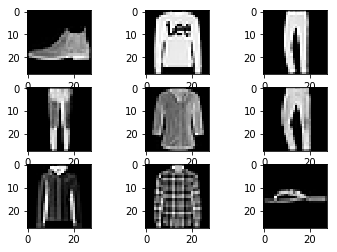

Reconstructed Images with Variational Autoencoder


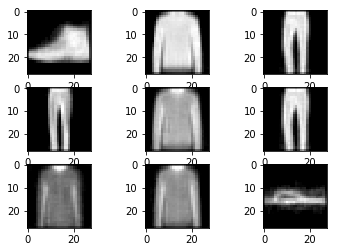

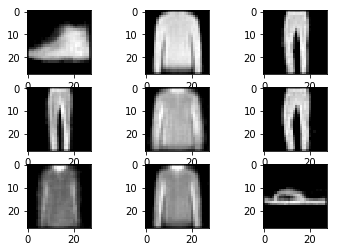

In [29]:
# ------------visualise the reconstructed by both AE and VAE------------
# Real Images
print("Real Images")
input = np.array(input)
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(input[i][0]*255, cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
output_vae = test_reconstructed_vae

for i in range(9):
    plt.subplot(330 + 1 + i)    
    op_image = output_vae[i][0]*255
    plt.imshow(op_image, cmap='gray')
plt.show()

output_ae = test_reconstructed_ae

for i in range(9):
    plt.subplot(330 + 1 + i)    
    op_image = output_ae[i][0]*255
    plt.imshow(op_image, cmap='gray')
plt.show()

In [30]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=2),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1),
}

In [31]:
# ----------get the encoding of the whole train set for AE------------
lreconstructed, lencoding = [], []
llabels=[]

def test():
    # Test the model   
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['train']:
            images=images.to('cuda')
            test_output = model_AE(images)
            reconstructed, encoding = test_output
            reconstructed, encoding = reconstructed.to('cpu'), encoding.to('cpu')           
            
            lreconstructed.append(np.array(reconstructed)); lencoding.append(np.array(encoding))
            llabels.append(np.array(labels))
    pass

test()

train_reconstructed_ae = np.vstack(lreconstructed)
train_encoding_ae = np.vstack(lencoding)
train_labels_ae = np.hstack(llabels)

[Text(0.5, 1.0, "MNIST training data sample's projection")]

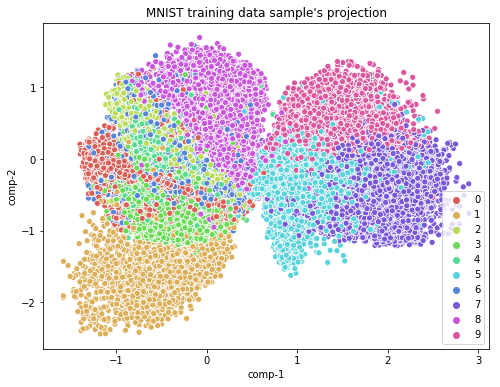

In [32]:
# ------------- visualisation of the feature space of training data using t-SNE -----------

from sklearn.manifold import TSNE
import pandas as pd
num_sample=40000

use_tSNE = False

if (use_tSNE):
    
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(train_encoding_ae[:num_sample])

else:
    
    z = train_encoding_ae[:num_sample]
    
y_ = train_labels_ae[:num_sample]
df = pd.DataFrame()
df["y"] = y_
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

fig, (ax1) = plt.subplots(1,1, figsize=(8,6))

import seaborn as sns
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df,ax=ax1
               ).set(title="MNIST training data sample's projection")

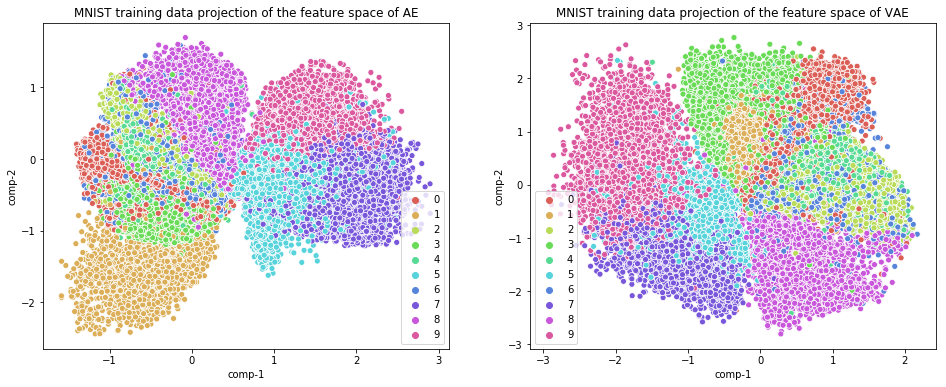

In [33]:
# -------------------------lets compare the feature space of VAE and AE ---------------------
import matplotlib.pyplot as plt
import numpy as np

num_samples_toCompare = 40000

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

z = train_encoding_ae[:num_samples_toCompare]
y_ = train_labels_ae[:num_samples_toCompare]
df = pd.DataFrame()
df["y"] = y_
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df,ax=ax1
               ).set(title="MNIST training data projection of the feature space of AE")

z = train_encoding_vae[:num_samples_toCompare]
y_ = train_labels_vae[:num_samples_toCompare]
df = pd.DataFrame()
df["y"] = y_
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df,ax=ax2
               ).set(title="MNIST training data projection of the feature space of VAE")
plt.show()
plt.close()

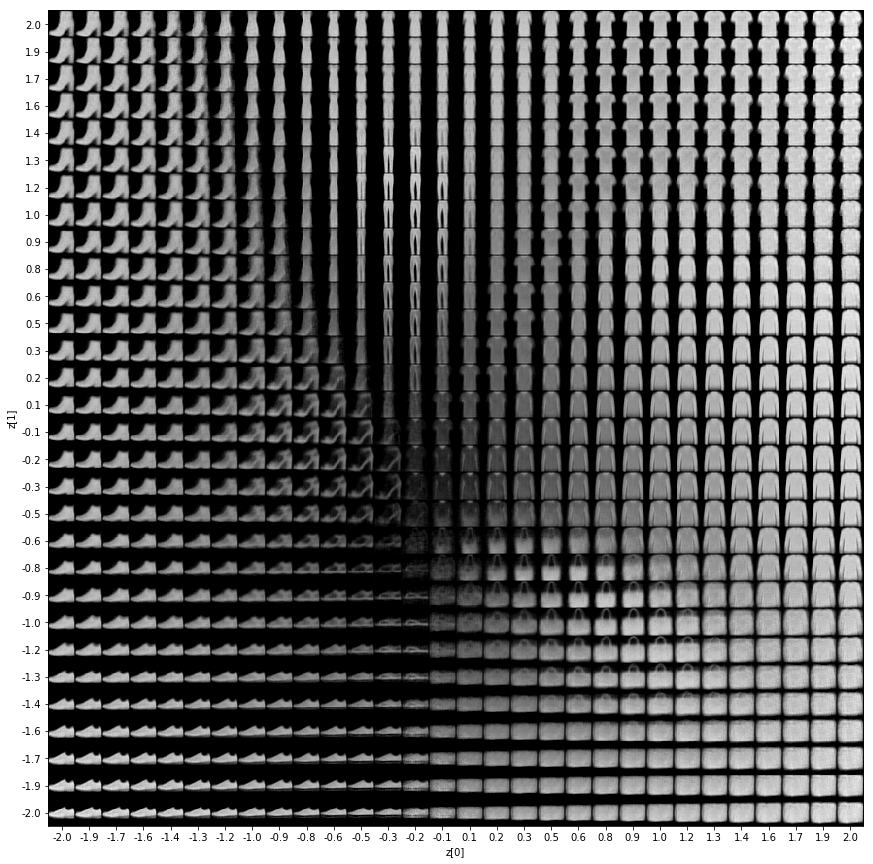

In [34]:
# Display a grid of sampled digits  

import matplotlib.pyplot as plt

def plot_latent_space(model, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]


    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]]).astype('float32')
            z_sample = torch.tensor(z_sample).to('cuda')
            x_decoded = model(z_sample).detach().to('cpu')
            
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model_VAE_decoder)

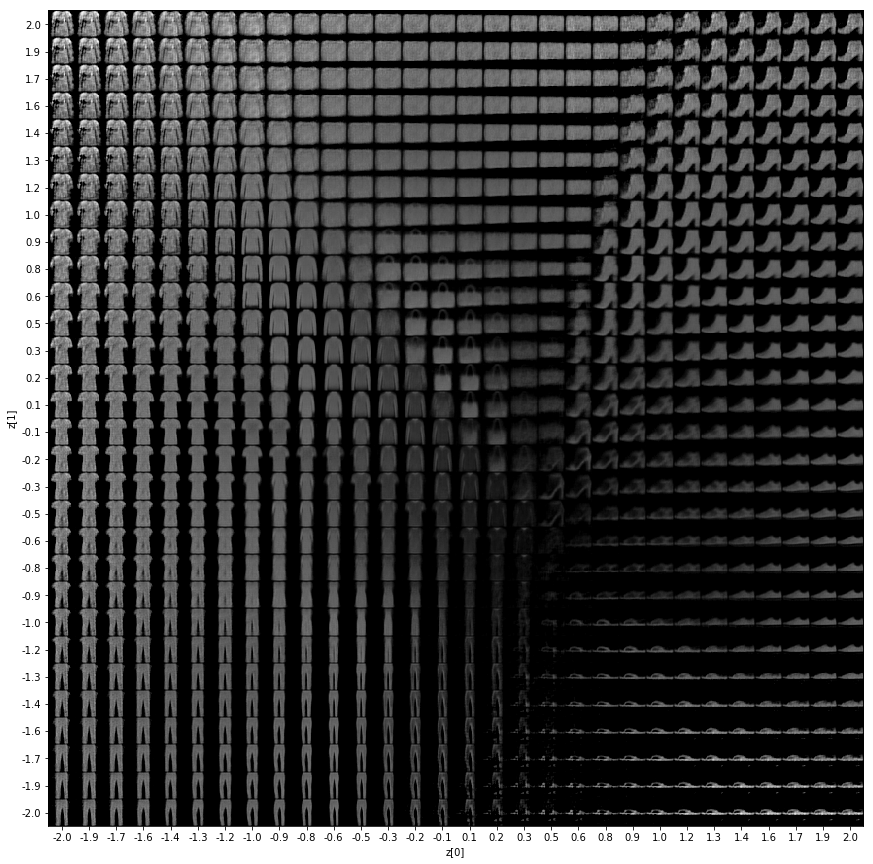

In [35]:
# Display a grid of sampled digits  

import matplotlib.pyplot as plt

def plot_latent_space(model, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]]).astype('float32')
            z_sample = torch.tensor(z_sample).to('cuda')
            x_decoded = model(z_sample).detach().to('cpu')
            
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model_AE_decoder)